# EOSC 511 Lab 7 
##Xiaoxin (Cindy) Yu

In [54]:
#!/usr/bin/env python
"""Interactive One.  Initialize a Gaussian bump in surface height and allow it evolve.  Note that under
rotational dynamics, the final steady state would be flow around the bump. If you chose the smaller domain size
even though the Coriolis force is still included, the scale is so small, its effect is negligible"""

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


def interactive1(grid, ngrid, dt, T, string, small=False):  # return eta
    '''recommended values ngrid=11, dt=150, T=4*3600 (4 hours), small=False OR
    ngrid=11, dt=4, T=90, small=True
    '''
    
    stepper = {1: stepgrid1, 2: stepgrid2, 3: stepgrid3}
    find_depth = {1: find_depth1, 2: find_depth2, 3: find_depth3}

# define rotation speed, gravity and depth
    f = 1e-4
    g = 10
    H0 = 1000

# set up spatial scale L is total domain size
    L = 1000e3

# make the domain depth and width smaller if small is True
    if small:
        H0 = 10
        L = 1000
        
    dx = L/(ngrid-1)

# write out dx/dt and sqrt(g*H) for comparison
    #print('dx/dt {0:.3f}\n'.format(dx/dt))
    #print('sqrt(g*H0) {0:.3f}\n'.format(np.sqrt(g*H0)))
    rdx = 1./dx

# set up Gaussian for forcing (its a bump in the center of the domain)
    x, y, spatial = findforcing(L, dx, ngrid)

# set up temporal scale T is total run time
    ntime = np.int(T/dt)

# initialize
    u, v, eta, up, vp, etap = initial(ngrid)

# set-up topography
    Hu, Hv = find_depth[grid](H0, ngrid, string)

    # main loop (leap-frog)
    for k in range(ntime):
        u, v, eta = stepper[grid](ngrid, f, g, Hu, Hv, dt, rdx, u, v, eta, up, vp, etap)

        # add forcing
        t = k * dt / 8640
        eta = eta + 0.1 * (1 - np.exp(-t*t)) * spatial

        # periodic boundary conditions
        u, v, eta = periodicbc(ngrid, u, v, eta)

        # exchange values
        u, v, eta, up, vp, etap = exchange(u, v, eta, up, vp, etap)

    # plot contours
    plotit(grid, ngrid, dx, x, y, u, v, eta)
    plotbathy(Hu,Hv,x,y,eta)

    return

def findforcing(L, dx, ngrid):
    '''define a two dimensional Gaussian of forcing with half-width L'''
    x = np.arange(0, L + 0.1*dx, dx)
    y = x  # symmetrical case
    spatial = np.zeros((ngrid, ngrid))

    for i in range(ngrid):
        for j in range(ngrid):
            spatial[i,j] = np.exp(-((y[j] - L/2.) * (y[j] - L/2)
                                    +(x[i] - L/2.) * (x[i] - L/2))
                                    /(L*L / 48.))
    return x, y, spatial

def find_depth1(H0, ngrid,string):
    print ('Flat Bottom')
    Hu = H0*np.ones((ngrid, ngrid))
    Hv = H0*np.ones_like(Hu)
    return Hu, Hv

def find_depth2(H0, ngrid,string):
    print ('Flat Bottom')
    Hu = H0*np.ones((ngrid, ngrid))
    Hv = H0*np.ones_like(Hu)
    return Hu, Hv


def initial(ngrid):
    '''initialize a ngrid x ngrid domain, u, v, and eta, all zero'''

    u = np.zeros((ngrid, ngrid))
    v = np.zeros_like(u)
    eta = np.zeros_like(u)

    up = np.zeros_like(u)
    vp = np.zeros_like(u)
    etap = np.zeros_like(u)

    return u, v, eta, up, vp, etap

def stepgrid1(ngrid, f, g, Hu, Hv, dt, rdx, u, v, eta, up, vp, etap):
    '''take a step forward using grid 1 (A)'''
    n = ngrid
    nm1 = ngrid-1
    nm2 = ngrid-2
    u[1:nm1, 1:nm1] = u[1:nm1, 1:nm1] + 2*dt * (f * vp[1:nm1, 1:nm1]
                                                - g * (etap[2:n, 1:nm1] - etap[0:nm2, 1:nm1]) * 0.5 * rdx)
    v[1:nm1, 1:nm1] = v[1:nm1, 1:nm1] + 2*dt * (-f * up[1:nm1, 1:nm1]
                                                - g *(etap[1:nm1,2:n] - etap[1:nm1, 0:nm2]) * 0.5 * rdx)
    eta[1:nm1, 1:nm1] = eta[1:nm1, 1:nm1] + 2*dt * (-(Hu[2:n, 1:nm1] * up[2:n, 1:nm1]
                                                      - Hu[0:nm2, 1:nm1] * up[0:nm2, 1:nm1]) * 0.5 * rdx
                                                    -(Hv[1:nm1, 2:n] * vp[1:nm1, 2:n]
                                                      - Hv[1:nm1, 0:nm2] * vp[1:nm1, 0:nm2]) * 0.5 * rdx)
    return u, v, eta

def stepgrid2(ngrid, f, g, Hu, Hv, dt, rdx, u, v, eta, up, vp, etap):
    '''take a step forward using grid 2 (B)'''
    n = ngrid
    nm1 = ngrid-1
    nm2 = ngrid-2
    u[1:nm1, 1:nm1] = u[1:nm1, 1:nm1] + 2*dt * (f * vp[1:nm1, 1:nm1]
                                                 -g * (etap[2:n, 1:nm1] - etap[1:nm1, 1:nm1]
                                                        + etap[2:n, 2:n] - etap[1:nm1, 2:n]) * 0.5 * rdx)
    v[1:nm1, 1:nm1] = v[1:nm1, 1:nm1] + 2*dt * (-f*up[1:nm1, 1:nm1]
                                                 - g * (etap[1:nm1, 2:n] - etap[1:nm1, 1:nm1]
                                                      + etap[2:n, 2:n] - etap[2:n, 1:nm1]) * 0.5 * rdx)
    eta[1:nm1, 1:nm1] = eta[1:nm1, 1:nm1] + 2*dt * (-(Hu[1:nm1, 1:nm1] * up[1:nm1, 1:nm1]
                                                      - Hu[0:nm2, 1:nm1] * up[0:nm2, 1:nm1]
                                                         + Hu[1:nm1, 0:nm2] * up[1:nm1, 0:nm2]
                                                         - Hu[0:nm2, 0:nm2] * up[0:nm2, 0:nm2]
                                                         + Hv[1:nm1, 1:nm1] * vp[1:nm1, 1:nm1]
                                                         - Hv[1:nm1, 0:nm2] * vp[1:nm1, 0:nm2]
                                                         + Hv[0:nm2, 1:nm1] * vp[0:nm2, 1:nm1]
                                                         - Hv[0:nm2, 0:nm2] * vp[0:nm2, 0:nm2]) * 0.5 * rdx)
    return u, v, eta

def stepgrid3(ngrid, f, g, Hu, Hv, dt, rdx, u, v, eta, up, vp, etap):
    '''take a step forward using grid 3 (C)'''
    n = ngrid
    nm1 = ngrid-1
    nm2 = ngrid-2
    vmid = np.zeros_like(u); umid = np.zeros_like(u) 
    vmid[1:nm1, 1:nm1] = (vp[1:nm1, 1:nm1] + vp[2:n, 1:nm1] + vp[1:nm1, 0:nm2] + vp[2:n, 0:nm2]) * 0.25
    umid[1:nm1, 1:nm1] = (up[1:nm1, 1:nm1] + up[1:nm1, 2:n] + up[0:nm2, 1:nm1] + up[0:nm2, 2:n]) * 0.25
    u[1:nm1, 1:nm1] = u[1:nm1, 1:nm1] + 2*dt * (f * vmid[1:nm1, 1:nm1]
                                                - g * (etap[2:n, 1:nm1] - etap[1:nm1, 1:nm1]) * rdx)
    v[1:nm1, 1:nm1] = v[1:nm1, 1:nm1] + 2*dt * (-f * umid[1:nm1, 1:nm1]
                                                - g *(etap[1:nm1, 2:n] - etap[1:nm1, 1:nm1]) * rdx)
    eta[1:nm1, 1:nm1] = eta[1:nm1, 1:nm1] + 2*dt * (-(Hu[1:nm1, 1:nm1] * up[1:nm1, 1:nm1]
                                                      - Hu[0:nm2, 1:nm1] * up[0:nm2, 1:nm1]) * rdx
                                                    -(Hv[1:nm1, 1:nm1] * vp[1:nm1, 1:nm1]
                                                      - Hv[1:nm1, 0:nm2] * vp[1:nm1, 0:nm2])* rdx)
    return u, v, eta

def periodicbc(ngrid, u, v, eta):
    '''do periodic boundary conditions'''
    eta[0, :] = eta[-2, :]
    eta[-1, :] = eta[1, :]
    eta[:, 0] = eta[:, -1]
    eta[:, -1] = eta[:, 1]

    u[0, :] = u[-2, :]
    u[-1, :] = u[1, :]
    u[:, 0] = u[:, -1]
    u[:, -1] = u[:, 1]

    v[0, :] = v[-2, :]
    v[-1, :] = v[1, :]
    v[:, 0] = v[:, -1]
    v[:, -1] = v[:, 1]

    return u, v, eta

def exchange(u, v, eta, up, vp, etap):
    '''swap new and old values'''
    store = np.zeros_like(vp)  # make sure store is its own array, not just another name for vp
    store = vp
    vp = v
    v = store
    store = up
    up = u
    u = store
    store = etap
    etap = eta
    eta = store

    return u, v, eta, up, vp, etap

def plotit(grid, ngrid, dx, x, y, u, v, eta):
    '''Contour plots of u, v, eta'''

    shift = {1: (0, 0), 2: (0.5, 0.5), 3: (0.5, 0)}
    
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    for i in range(2):
        ax[1,i].set_xlabel('x (km)')
        ax[i,0].set_ylabel('y (km)')
    ax[0,0].set_title('$\eta$')
    ax[0,1].set_title('velocity')
    ax[1,0].set_title('u')
    ax[1,1].set_title('v')
    a=ax[0,0].contour(x/1000, y/1000, eta.transpose())
    plt.clabel(a, inline=1, fontsize=10)
    b=ax[1,0].contour((x + shift[grid][0] * dx)/1000,
                  (y + shift[grid][1] * dx)/1000, u.transpose())
    plt.clabel(b, inline=1, fontsize=10)
    c=ax[1,1].contour((x + shift[grid][1] * dx)/1000,
                  (y + shift[grid][0] * dx)/1000, v.transpose())
    plt.clabel(c, inline=1, fontsize=10)

    if grid == 3:
        ax[0,1].quiver(x[1:]/1000., y[1:]/1000,
                       0.5 * (u[1:,1:] + u[1:,:-1]).transpose(),
                       0.5 * (v[1:,1:] + v[1:,:-1]).transpose())
#                       0.5 * (u[1:,1:] + u[:-1,1:]).transpose(),
#                       0.5 * (v[1:,1:] + v[1:,:-1]).transpose())
    else:
        ax[0,1].quiver(x/1000, y/1000, u.transpose(), v.transpose())
        
    fig = plt.figure()

        
def plotbathy(Hu,Hv,x,y,eta):
    
    
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    X = x/1000
    Y = y/1000
    X, Y = np.meshgrid(X, Y)
    Z = Hu#(Hu**2+Hv**2)**0.5
    
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.3)
    cset = ax.contour(X, Y, Z, zdir='z', offset=Z.max(), cmap=cm.coolwarm,alpha=0.3)
    cset = ax.contour(X, Y, Z, zdir='x', offset=X.min(), cmap=cm.coolwarm,alpha=0.3)
    cset = ax.contour(X, Y, Z, zdir='y', offset=Y.max(), cmap=cm.coolwarm,alpha=0.3)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Depth')
    plt.title('Topography')
    ax.invert_zaxis()

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    X = x/1000
    Y = y/1000
    X, Y = np.meshgrid(X, Y)
    Z = eta.transpose()
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.3)
    cset = ax.contour(X, Y, Z, zdir='z', offset=Z.min(), cmap=cm.coolwarm,alpha=0.9)
    cset = ax.contour(X, Y, Z, zdir='x', offset=X.min(), cmap=cm.coolwarm,alpha=0.9)
    cset = ax.contour(X, Y, Z, zdir='y', offset=Y.max(), cmap=cm.coolwarm,alpha=0.9)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('ETA')
    plt.title('ETA')
    plt.show()
        
def makeGaussian(size):
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    y0=size/2
    x0=size/2
    fwhm = 1/5*size
    gauss=1000*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    return gauss
        
        
def find_depth3(H0, ngrid,string):
    if string=='flat':
        print ('Flat Bottom')
        H = H0*np.ones((2*ngrid, 2*ngrid))
        Hv = H[0::2,1::2]
        Hu = H[1::2,0::2]
        
    if string=='flat2':
        print ('Flat Bottom2')
        H = 50**np.ones((2*ngrid, 2*ngrid))
        Hv = H[0::2,1::2]
        Hu = H[1::2,0::2]

    if string=='M':
        print ('sin function (x direction)')
        H = H0*np.ones((2*ngrid, 2*ngrid))
        for j in range (2*ngrid): 
            H[:,j]      =H[:,j]*np.sin(np.pi/(2*ngrid-2)*j)
        Hv = H[0::2,1::2]
        Hu = H[1::2,0::2]
    
        
    if string=='M3':    
        print ('Gaussian Bottom')
        Hu=H0*np.ones((ngrid, ngrid))-makeGaussian(ngrid)
        Hv=Hu
 
    return Hu, Hv


/home/xiaoxiny/anaconda/envs/mypython3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/xiaoxiny/anaconda/envs/mypython3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


sin function (x direction)


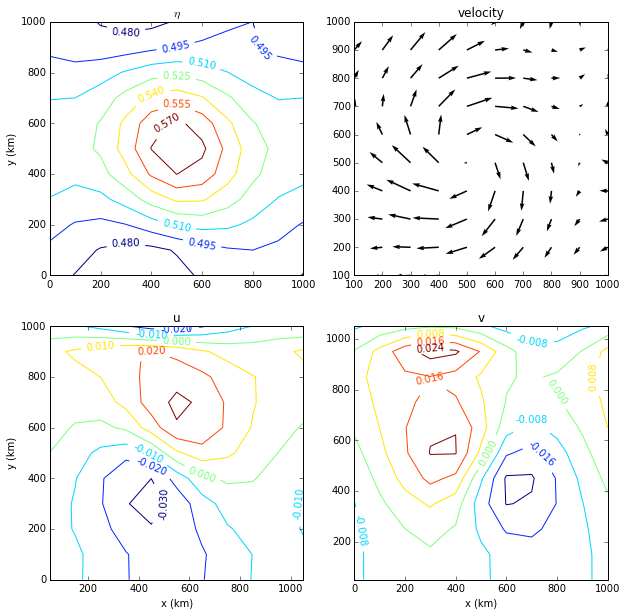

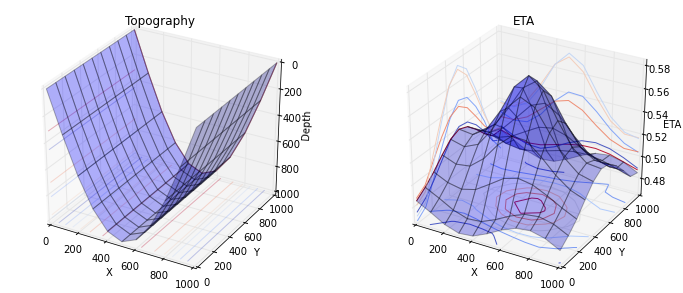

In [55]:
%matplotlib inline
interactive1(3, 11, 150, 8*3600, 'M',small=False) # return eta

/home/xiaoxiny/anaconda/envs/mypython3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/xiaoxiny/anaconda/envs/mypython3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


Gaussian Bottom


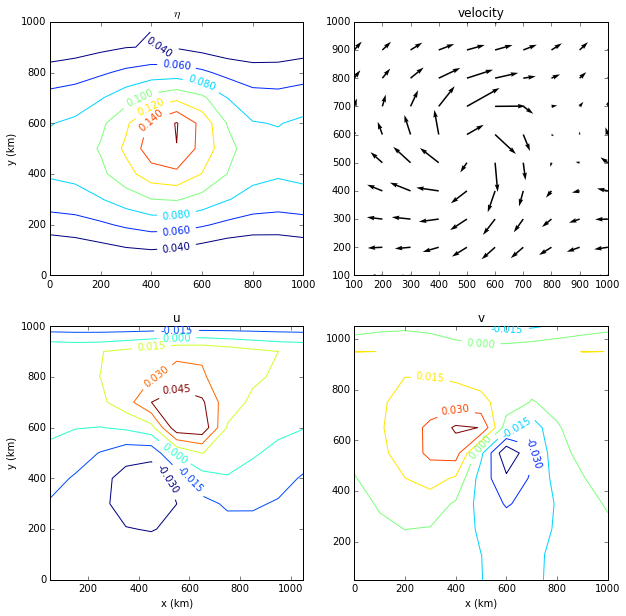

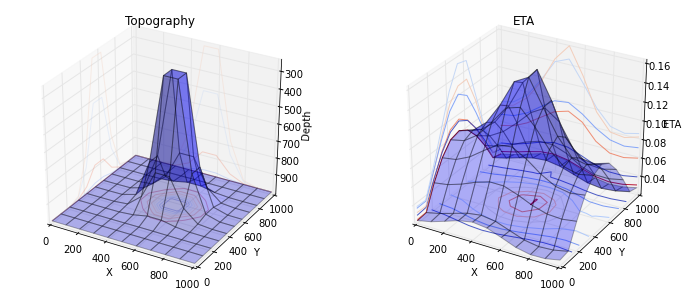

In [26]:
interactive1(3, 11, 150, 8*3600, 'M3',small=False) 

/home/xiaoxiny/anaconda/envs/mypython3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/xiaoxiny/anaconda/envs/mypython3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


Flat Bottom


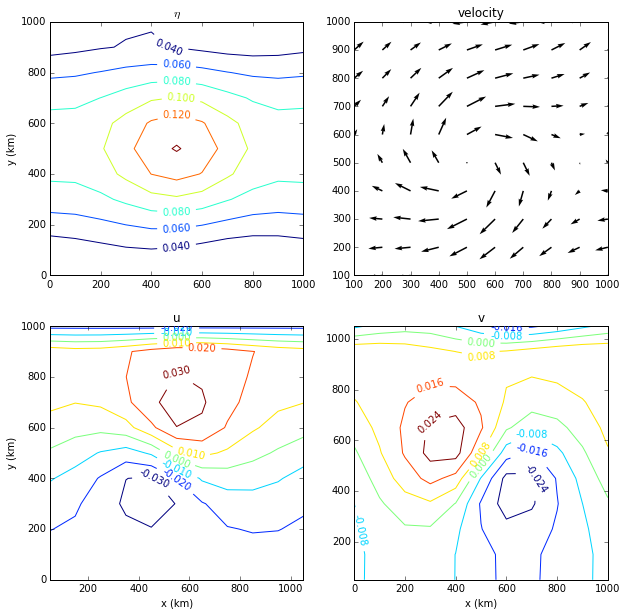

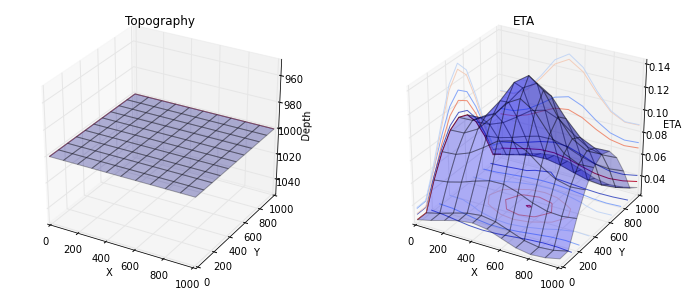

In [74]:
interactive1(3, 11, 150, 8*3600, 'flat',small=False) # return eta